In [1]:
# Connect WRDS
import wrds

db = wrds.Connection(wrds_username='yanqinglin')

Loading library list...
Done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
from pandas_datareader import data as pdr
import datetime
import wrds
import warnings
from scipy.optimize import minimize
warnings.filterwarnings('ignore')

Retrieving Barrick Gold's debt data...
=== Quarterly Debt Data (debt_quarterly) ===
             gvkey   dlttq  dlcq            Lt
datadate                                      
2023-12-31  002055  5180.0  43.0  2633000000.0
2024-03-31  002055  4713.0  12.0  2368500000.0
2024-06-30  002055  4713.0  11.0  2367500000.0
2024-09-30  002055  4712.0  13.0  2369000000.0
2024-12-31  002055  5172.0  84.0  2670000000.0

=== Daily Interpolated Debt Data (daily_debt) ===
                           Lt
date                         
2023-12-31       2633000000.0
2024-01-01  2630093406.593407
2024-01-02  2627186813.186813
2024-01-03   2624280219.78022
2024-01-04  2621373626.373626
...                       ...
2024-12-27  2656913043.478261
2024-12-28  2660184782.608696
2024-12-29   2663456521.73913
2024-12-30  2666728260.869565
2024-12-31       2670000000.0

[367 rows x 1 columns]


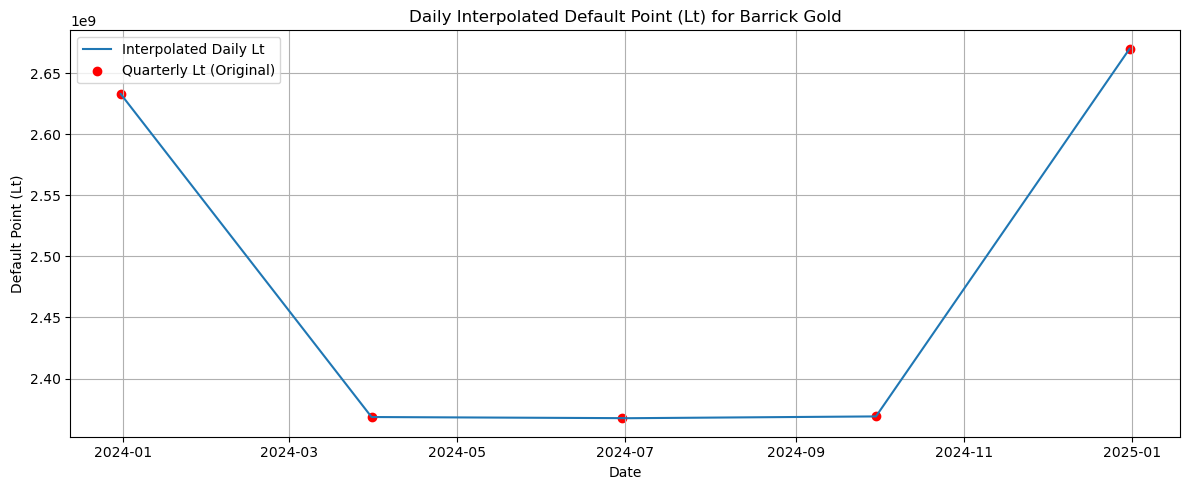

In [3]:
# Question 1
# Retrieve debt data from Compustat for Barrick Gold
print("Retrieving Barrick Gold's debt data...")
query_debt = """
SELECT datadate, gvkey, dlttq, dlcq
FROM comp.fundq
WHERE gvkey = '002055' 
  AND datadate BETWEEN '2023-10-01' AND '2024-12-31'
ORDER BY datadate
"""
debt_quarterly = db.raw_sql(query_debt)

# Convert date column to datetime format
debt_quarterly['datadate'] = pd.to_datetime(debt_quarterly['datadate'])

# Calculate default point Lt as current liabilities + 50% of long-term debt
# dlcq and dlttq are in million USD
debt_quarterly['Lt'] = (debt_quarterly['dlcq'] + 0.5 * debt_quarterly['dlttq']) * 1000000

# Set the date as the index
debt_quarterly.set_index('datadate', inplace=True)

# Create a daily date range covering the period of the available data
daily_dates = pd.date_range(start=debt_quarterly.index.min(), end=debt_quarterly.index.max())
daily_debt = pd.DataFrame(index=daily_dates)

# Join and interpolate quarterly data to get daily values
daily_debt = daily_debt.join(debt_quarterly[['Lt']])
daily_debt = daily_debt.interpolate(method='linear')
daily_debt.index.name = "date"

# Display the original quarterly debt data
print("=== Quarterly Debt Data (debt_quarterly) ===")
print(debt_quarterly)

# Display the interpolated daily debt data
print("\n=== Daily Interpolated Debt Data (daily_debt) ===")
print(daily_debt)

# Plot the interpolated default point over time
plt.figure(figsize=(12, 5))
plt.plot(daily_debt.index, daily_debt['Lt'], label='Interpolated Daily Lt')
plt.scatter(debt_quarterly.index, debt_quarterly['Lt'], color='red', label='Quarterly Lt (Original)')
plt.title('Daily Interpolated Default Point (Lt) for Barrick Gold')
plt.xlabel('Date')
plt.ylabel('Default Point (Lt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
pd.DataFrame(daily_debt)

,Lt
date,
2023-12-31,2633000000.0
2024-01-01,2630093406.593407
2024-01-02,2627186813.186813
2024-01-03,2624280219.78022
2024-01-04,2621373626.373626
...,...
2024-12-27,2656913043.478261
2024-12-28,2660184782.608696
2024-12-29,2663456521.73913


Retrieving Barrick Gold's stock price and shares outstanding...
=== Daily Market Capitalization ===
                    market_cap
date                          
2024-01-02       31397280000.0
2024-01-03  30431479999.999996
2024-01-04  30466600000.000004
2024-01-05  30712439999.999996
2024-01-08  31063640000.000004
...                        ...
2024-12-24       27461849790.0
2024-12-26       27514291260.0
2024-12-27       27409408320.0
2024-12-30       27024837540.0
2024-12-31       27094759500.0

[252 rows x 1 columns]


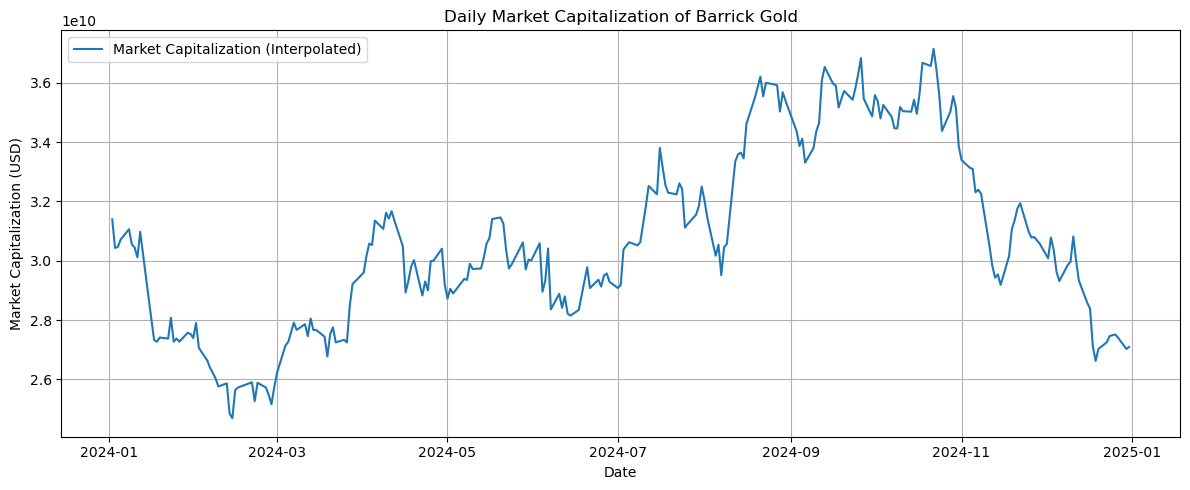

In [5]:
# Question 2
# Get stock price and shares outstanding from CRSP
print("Retrieving Barrick Gold's stock price and shares outstanding...")
query_stock = """
SELECT date, prc, shrout
FROM crsp.dsf
WHERE permno = 71298
  AND date BETWEEN '2023-12-31' AND '2024-12-31'
ORDER BY date
"""
stock_data = db.raw_sql(query_stock)

# Convert date column and clean up
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data['prc'] = stock_data['prc'].abs()  # Ensure positive prices
stock_data['shrout'] = stock_data['shrout'] * 1000  # Convert from thousands to shares
stock_data['market_cap'] = stock_data['prc'] * stock_data['shrout']
stock_data.set_index('date', inplace=True)
stock_data = stock_data.sort_index()  # Ensure chronological order

# Keep only market cap
stock_data = stock_data[['market_cap']]

# Print the daily market capitalization after interpolation
print("=== Daily Market Capitalization ===")
print(stock_data)

# Plot the daily market capitalization time series
plt.figure(figsize=(12, 5))
plt.plot(stock_data.index, stock_data['market_cap'], label='Market Capitalization (Interpolated)')
plt.title('Daily Market Capitalization of Barrick Gold')
plt.xlabel('Date')
plt.ylabel('Market Capitalization (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
pd.DataFrame(stock_data)

,market_cap
date,
2024-01-02,31397280000.0
2024-01-03,30431479999.999996
2024-01-04,30466600000.000004
2024-01-05,30712439999.999996
2024-01-08,31063640000.000004
...,...
2024-12-24,27461849790.0
2024-12-26,27514291260.0
2024-12-27,27409408320.0


In [7]:
# Question 3
# Retrieve risk-free rate (1-year zero-coupon yield from St. Louis Fed)
print("Fetching 1-year zero-coupon Treasury yield...")

start_date = debt_quarterly.index.min()
end_date = debt_quarterly.index.max()

risk_free_data = pdr.get_data_fred('THREEFY1', start=start_date, end=end_date)
risk_free_data = risk_free_data / 100  # Convert from percentage to decimal
risk_free_data.index = pd.to_datetime(risk_free_data.index)
risk_free_data = risk_free_data.dropna()

print("Successfully retrieved risk-free rate data:")
print(risk_free_data)

Fetching 1-year zero-coupon Treasury yield...
Successfully retrieved risk-free rate data:
            THREEFY1
DATE                
2024-01-02  0.047805
2024-01-03  0.047802
2024-01-04  0.048062
2024-01-05  0.048169
2024-01-08  0.047959
...              ...
2024-12-24  0.043222
2024-12-26  0.043109
2024-12-27  0.043011
2024-12-30  0.042641
2024-12-31  0.042575

[250 rows x 1 columns]


In [8]:
pd.DataFrame(risk_free_data)

,THREEFY1
DATE,
2024-01-02,0.047805
2024-01-03,0.047802
2024-01-04,0.048062
2024-01-05,0.048169
2024-01-08,0.047959
...,...
2024-12-24,0.043222
2024-12-26,0.043109
2024-12-27,0.043011


In [9]:
# Ensure all indices are datetime and sorted
stock_data = stock_data.sort_index()
daily_debt = daily_debt.sort_index()
risk_free_data = risk_free_data.sort_index()

# Combine all datasets into one DataFrame by date
data = pd.concat([
    daily_debt[['Lt']],
    stock_data[['market_cap']],
    risk_free_data.rename(columns={'THREEFY1': 'risk_free_rate'})
], axis=1)

# Trim the data to start from the first date where Lt is available
data = data.loc[data['market_cap'].first_valid_index():]
data = data.dropna()

# Display result
print("=== Combined Daily Data ===")
print(data)

=== Combined Daily Data ===
                           Lt          market_cap  risk_free_rate
2024-01-02  2627186813.186813       31397280000.0        0.047805
2024-01-03   2624280219.78022  30431479999.999996        0.047802
2024-01-04  2621373626.373626  30466600000.000004        0.048062
2024-01-05  2618467032.967033  30712439999.999996        0.048169
2024-01-08  2609747252.747253  31063640000.000004        0.047959
...                       ...                 ...             ...
2024-12-24  2647097826.086957       27461849790.0        0.043222
2024-12-26  2653641304.347826       27514291260.0        0.043109
2024-12-27  2656913043.478261       27409408320.0        0.043011
2024-12-30  2666728260.869565       27024837540.0        0.042641
2024-12-31       2670000000.0       27094759500.0        0.042575

[250 rows x 3 columns]


In [10]:
from tqdm import tqdm

def merton_model(asset, debt, rf, sigma, t=1):
    """
    Calculate equity value using the Merton model
    
    Parameters:
    asset: Asset value
    debt: Debt face value
    rf: Risk-free rate
    sigma: Asset volatility
    t: Time to maturity in years
    
    Returns:
    Equity value according to the Merton model
    """
    d1 = (np.log(asset / debt) + (rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return asset * norm.cdf(d1) - debt * np.exp(-rf * t) * norm.cdf(d2)

def asset_value_row(row, sigma, t=1):
    """
    Calculate implied asset value for a single row using the Merton model
    
    Parameters:
    row: DataFrame row containing market_cap, Lt, and risk_free_rate
    sigma: Asset volatility
    t: Time to maturity in years
    
    Returns:
    Implied asset value
    """
    equity = row['market_cap']
    debt = row['Lt']
    rf = row['risk_free_rate']
    
    # Define the objective function: we want merton_model(asset, ...) == equity
    objective = lambda asset: merton_model(asset, debt, rf, sigma, t) - equity
    initial_guess = equity + debt  # A common initial guess: equity plus debt
    
    # Use a timeout to prevent excessive computation
    asset = fsolve(objective, initial_guess, xtol=1e-6, maxfev=100)[0]
    return asset

def vectorized_asset_values(data, sigma, t=1):
    """
    Calculate asset values for all rows more efficiently
    
    This function applies asset_value_row to each row but can be optimized
    further with actual vectorization if the structure allows.
    """
    # This could be optimized further if merton_model can be truly vectorized
    assets = []
    for _, row in tqdm(data.iterrows(), total=len(data), desc="Calculating asset values", disable=True):
        try:
            asset_value = asset_value_row(row, sigma, t)
            assets.append(asset_value)
        except:
            # Handle potential errors in fsolve
            assets.append(np.nan)
    
    return pd.Series(assets, index=data.index)

def calculate_merton_model(data, max_iterations=50, tolerance=1e-10):
    """
    Run the Merton model iterations until convergence
    
    Parameters:
    data: DataFrame containing market_cap, Lt, and risk_free_rate
    max_iterations: Maximum number of iterations to perform
    tolerance: Convergence tolerance for sigma
    
    Returns:
    Tuple of (asset_values, final_sigma, convergence_history)
    """
    # Make a copy of the data to avoid modifying the original
    data = data.copy()
    
    # Initialize variables
    data['log_return'] = np.log(data['market_cap'] / data['market_cap'].shift(1))
    sigma_0 = data['log_return'].std() * np.sqrt(252)
    #sigma_0 = 0
    
    iteration = 0
    converged = False
    
    print(f"Starting with initial sigma: {sigma_0:.6f}")
    
    # Main iteration loop - continue until convergence
    while not converged and iteration < max_iterations:
        iteration += 1
        
        # Step 1: Calculate asset values using current sigma
        data['asset_value'] = vectorized_asset_values(data, sigma=sigma_0, t=1)
        
        # Step 2: Calculate log returns from these asset values
        data['asset_log_return'] = np.log(data['asset_value'] / data['asset_value'].shift(1))
        
        # Step 3: Calculate new sigma as standard deviation of log returns
        # Drop NaN values that might appear in the first row or from errors
        sigma_1 = data['asset_log_return'].dropna().std() * np.sqrt(252)
        
        # Record convergence history
        sigma_diff = abs(sigma_1 - sigma_0)
        
        # Step 4: Check convergence
        if sigma_diff < tolerance:
            converged = True
            print(f"Converged after {iteration} iterations!")
        else:
            # Update sigma for next iteration
            sigma_0 = sigma_1
    
    if not converged:
        print(f"Failed to converge after {max_iterations} iterations.")
    
    # Final calculation with the converged sigma
    final_assets = vectorized_asset_values(data, sigma=sigma_1, t=1)
    final_asset_value = final_assets.iloc[-1]

    print(f"Estimated Asset Volatility: {sigma_1:.6f}")
    print(f"Estimated Asset Value at 2024-12-31: {final_asset_value:.2f} USD")
    
    return final_assets, sigma_1

In [11]:
asset_values, final_sigma = calculate_merton_model(data, max_iterations=20, tolerance=1e-9)

Starting with initial sigma: 0.342291
Converged after 2 iterations!
Estimated Asset Volatility: 0.317895
Estimated Asset Value at 2024-12-31: 29653470132.45 USD


=== Default Frontier (Quarterly) ===
    Default Point
0    2.538316e+09
1    2.670000e+09
2    2.801684e+09
3    2.933368e+09
4    3.065053e+09
5    3.196737e+09
6    3.328421e+09
7    3.460105e+09
8    3.591789e+09
9    3.723474e+09
10   3.855158e+09
11   3.986842e+09
12   4.118526e+09
13   4.250211e+09
14   4.381895e+09
15   4.513579e+09
16   4.645263e+09
17   4.776947e+09
18   4.908632e+09
19   5.040316e+09
20   5.172000e+09


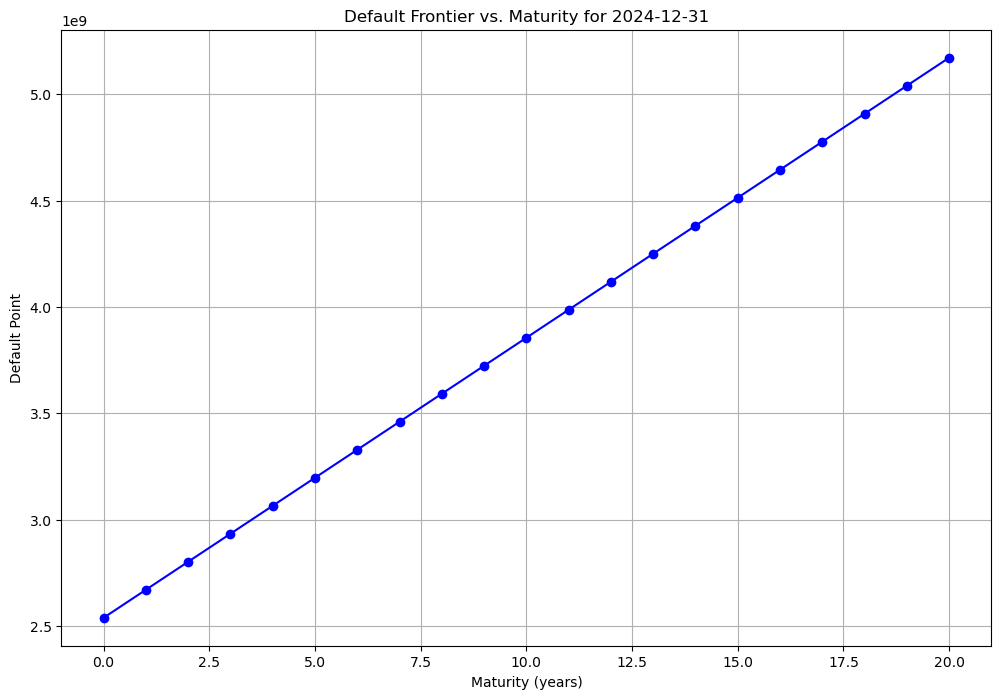

In [12]:
# Question 4
# Data Preparation
lt = debt_quarterly.Lt[-1]  
dlttq = debt_quarterly.dlttq[-1] * 1_000_000  # Convert to the correct scale (dollars)

# Calculate Default Frontier

# Create an array for maturities: from 0 to 20 years (a total of 21 values)
maturities = np.arange(0, 21)

# Calculate the default point for each maturity using vectorized operations
default_points = lt + ((maturities - 1) / (20 - 1)) * (dlttq - lt)

# Construct a DataFrame with the maturities as the index and a single column named "Default Point"
default_frontier_df = pd.DataFrame(default_points, index=maturities, columns=["Default Point"])

# Print the generated DataFrame
print("=== Default Frontier (Quarterly) ===")
print(default_frontier_df)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(default_frontier_df.index, default_frontier_df["Default Point"], marker='o', color='blue')
plt.title("Default Frontier vs. Maturity for 2024-12-31")
plt.xlabel("Maturity (years)")
plt.ylabel("Default Point")
plt.grid(True)
plt.show()

In [13]:
# Question 5
# Organize the data
# Map each maturity (in years) to its corresponding FRED series code
fred_series = {
    1: "THREEFY1",    # 1-year zero-coupon yield
    2: "THREEFY2",    # 2-year zero-coupon yield
    3: "THREEFY3",    # 3-year zero-coupon yield
    4: "THREEFY4",    # 4-year zero-coupon yield
    5: "THREEFY5",    # 5-year zero-coupon yield
    6: "THREEFY6",    # 6-year zero-coupon yield
    7: "THREEFY7",    # 7-year zero-coupon yield
    8: "THREEFY8",    # 8-year zero-coupon yield
    9: "THREEFY9",    # 9-year zero-coupon yield
    10: "THREEFY10"  # 10-year zero-coupon yield
}

# NSS parameters from St-Louis Fed for 2025-01-02
beta0 = 1.3997809781669e-05
beta1 = 4.17537838746407
beta2 = -124.32776755909
beta3 = 134.379235533314
tau1 = 12.3652373905849
tau2 = 12.9049079240786

def nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1))
    term3 = beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1))
    term4 = beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2))
    return term1 + term2 + term3 + term4

maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
risk_free_yields = nss_curve(maturities, beta0, beta1, beta2, beta3, tau1, tau2)


# Set the target date for which you want to retrieve data
target_date = "2025-01-02" 

# Fetch data for each series from FRED, restricted to the target date
rf_data = {}
for maturity, series in fred_series.items():
    data = pdr.get_data_fred(series, start=target_date, end=target_date)
    if not data.empty:  # Check if any data was returned
        rf_data[maturity] = data[series].iloc[0]
for t in range(11, 21):
    rf_data[t] = nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2)

rf_data_df = pd.DataFrame.from_dict(rf_data, orient='index', columns=["Yield"])

# Convert the dictionary into a DataFrame for easier viewing
combined_df = default_frontier_df.join(rf_data_df, how='left')
df = combined_df.dropna()

In [14]:
rf_data_df 

,Yield
1,4.249100
2,4.243300
3,4.242500
4,4.258200
5,4.291700
6,4.340500
7,4.401000
8,4.470100
9,4.545000
10,4.623500


In [15]:
risk_free_yields

array([4.19191262, 4.21894287, 4.25407113, 4.29521372, 4.34057845,
       4.38863145, 4.43806749, 4.48778333, 4.53685378, 4.58451036,
       4.63012209, 4.67317847, 4.71327413, 4.75009525, 4.78340741,
       4.81304483, 4.83890074, 4.8609189 , 4.87908605, 4.89342529])

=== Term Structure of Credit Spread ===
1     9.783840e-12
2     3.499947e-05
3     5.782495e-03
4     7.461362e-02
5     3.439504e-01
6     9.435585e-01
7     1.920286e+00
8     3.239721e+00
9     4.821737e+00
10    6.573069e+00
11    8.570450e+00
12    1.055797e+01
13    1.255130e+01
14    1.451340e+01
15    1.641913e+01
16    1.825279e+01
17    2.000589e+01
18    2.167520e+01
19    2.326126e+01
20    2.476715e+01
Name: Credit Spread, dtype: float64


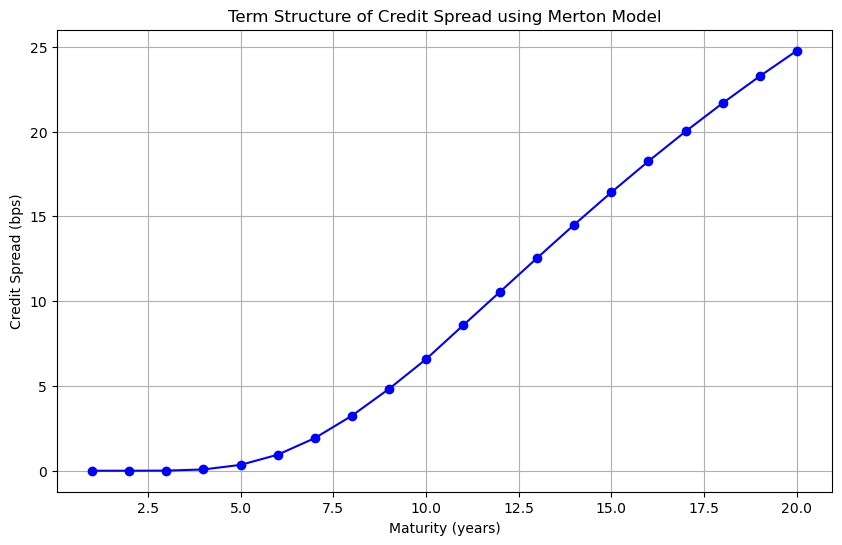

In [16]:
import numpy as np
from scipy.stats import norm
import pandas as pd

# Input Data
# Asset value and volatility on 2024-12-31
v = asset_values.iloc[-1]
volatility = final_sigma
rf = df.Yield / 100
debt = df["Default Point"]

# Select maturities from the debt DataFrame that are >= 1 year
maturities = debt.index[debt.index >= 1]

credit_spreads = []

# Loop over each maturity T to calculate the credit spread
for T in maturities:
    M = debt.loc[T]      # Default boundary (debt level) at this maturity
    r = rf.loc[T]        # Risk-free rate at this maturity
    
    # Calculate d1 and d2 using the Merton model formulas
    d1 = (np.log(v / M) + (r + 0.5 * volatility**2) * T) / (volatility * np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)
    
     # Calculate D according to the Merton model
    D = M * np.exp(-r * T) * norm.cdf(d2) + v * norm.cdf(-d1)
    
    # Calculate the credit spread (converted to basis points)
    spread = (-1 / T * np.log(D / M) - r) * 10000
    
    credit_spreads.append(spread)

# Convert the calculated results into a Series with maturities as the index
credit_spread_series = pd.Series(credit_spreads, index=maturities, name="Credit Spread")

# Print the resulting table
print("=== Term Structure of Credit Spread ===")
print(credit_spread_series)

# Plot the term structure of credit spreads
plt.figure(figsize=(10, 6))
plt.plot(credit_spread_series.index, credit_spread_series, marker='o', linestyle='-', color='b')
plt.xlabel("Maturity (years)")
plt.ylabel("Credit Spread (bps)")
plt.title("Term Structure of Credit Spread using Merton Model")
plt.grid(True)
plt.show()

Current Asset/Debt Ratio: 11.106168588931437 maturities: 1
Current Asset/Debt Ratio: 10.584158636092798 maturities: 2
Current Asset/Debt Ratio: 10.109016623900883 maturities: 3
Current Asset/Debt Ratio: 9.674701774100072 maturities: 4
Current Asset/Debt Ratio: 9.27616866733333 maturities: 5
Current Asset/Debt Ratio: 8.909170343398037 maturities: 6
Current Asset/Debt Ratio: 8.570106363002218 maturities: 7
Current Asset/Debt Ratio: 8.255904292194066 maturities: 8
Current Asset/Debt Ratio: 7.9639263352909255 maturities: 9
Current Asset/Debt Ratio: 7.691895103163114 maturities: 10
Current Asset/Debt Ratio: 7.437834092626955 maturities: 11
Current Asset/Debt Ratio: 7.200019584374736 maturities: 12
Current Asset/Debt Ratio: 6.97694148297907 maturities: 13
Current Asset/Debt Ratio: 6.767271217888101 maturities: 14
Current Asset/Debt Ratio: 6.569835263374751 maturities: 15
Current Asset/Debt Ratio: 6.383593162434758 maturities: 16
Current Asset/Debt Ratio: 6.207619185523587 maturities: 17
Curr

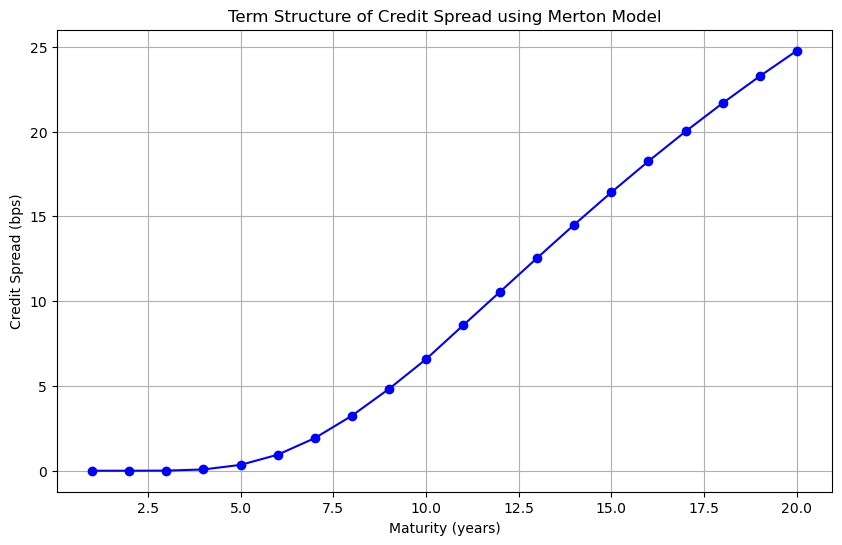

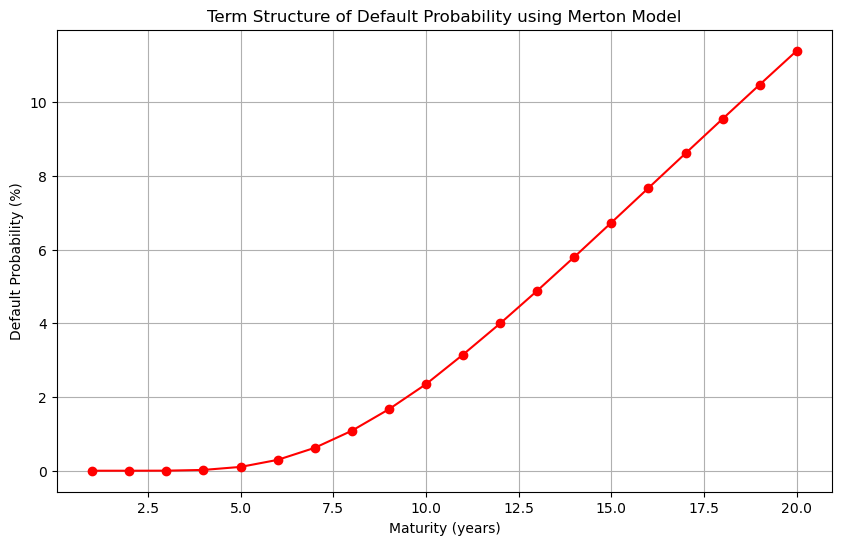

In [17]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

# Input Data
# Asset value and volatility on 2024-12-31
v = asset_values.iloc[-1]
volatility = final_sigma
rf = df.Yield / 100
debt = df["Default Point"]

# Select maturities (in years) from the debt DataFrame that are >= 1 year
maturities = debt.index[debt.index >= 1]

credit_spreads = []
default_probabilities = [] # List to store default probabilities
default_distance = []

# Loop over each maturity T to calculate the credit spread and default probability
for T in maturities:
    M = debt.loc[T]      # Default boundary (or debt level) at this maturity (used as M)
    r = rf.loc[T]        # Risk-free rate at this maturity   
    
    # Calculate d1 and d2 using the Merton model formulas
    d1 = (np.log(v / M) + (r + 0.5 * volatility**2) * T) / (volatility * np.sqrt(T))
    #d1 = (np.log(4) + (r + 0.5 * volatility**2) * T) / (volatility * np.sqrt(T))

    d2 = d1 - volatility * np.sqrt(T)

    asset_debt_ratio = v / M
    print(f"Current Asset/Debt Ratio: {asset_debt_ratio}", f"maturities: {T}")
    
    # Calculate D (the model-implied risky debt price) according to the Merton model:
    # D = M * exp(-r * T)* N(d2) + v * N(-d1)
    D = M * np.exp(-r * T) * norm.cdf(d2) + v * norm.cdf(-d1)
    
    # Calculate the credit spread in basis points (bps)
    spread = (-1 / T * np.log(D / M) - r) * 10000
    credit_spreads.append(spread)
    
    # Calculate the default probability
    # In the Merton model, the risk-neutral default probability is approximated by N(-d2)
    DD = d2
    PD = norm.cdf(-d2)
    default_probabilities.append(PD)
    default_distance.append(DD)

# Convert the calculated results into Series with maturities as the index
credit_spread_series = pd.Series(credit_spreads, index=maturities, name="Credit Spread")
default_probability_series = pd.Series(default_probabilities, index=maturities, name="Default Probability")
default_distance_series = pd.Series(default_distance, index=maturities, name="Default Distance")

# Print the resulting term structure tables
print("=== Term Structure of Credit Spread ===")
print(credit_spread_series)
print("\n=== Term Structure of Default Probability ===")
print(default_probability_series)
print("\n=== Term Structure of Default Distance ===")
print(default_distance_series)

# Plot the term structure of credit spreads
plt.figure(figsize=(10, 6))
plt.plot(credit_spread_series.index, credit_spread_series, marker='o', linestyle='-', color='b')
plt.xlabel("Maturity (years)")
plt.ylabel("Credit Spread (bps)")
plt.title("Term Structure of Credit Spread using Merton Model")
plt.grid(True)
plt.show()

# Plot the term structure of default probabilities (displayed in percentage)
plt.figure(figsize=(10, 6))
plt.plot(default_probability_series.index, default_probability_series*100, marker='o', linestyle='-', color='r')
plt.xlabel("Maturity (years)")
plt.ylabel("Default Probability (%)")
plt.title("Term Structure of Default Probability using Merton Model")
plt.grid(True)
plt.show()

In [18]:
db.close()